# Melanoma Detection Project

## Objective
The goal of this project is to build a machine learning model that can accurately differentiate between benign and malignant melanoma in skin lesion images. This work aims to assist dermatologists in diagnosing skin cancer more efficiently and with greater accuracy.

## Background
Melanoma is a type of skin cancer that can be life-threatening if not diagnosed early. Automated tools to detect and classify skin lesions as malignant or benign can significantly enhance diagnostic processes in clinical settings.

## Data Source
This project utilizes the melanoma dataset available on [Kaggle](https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset), which includes labeled images of skin lesions.


In [28]:
## Imports
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm


# Exploratory Data Analysis

## Overview
This section explores the dataset to understand the distribution of data, identify any inconsistencies, and make preliminary observations. The insights gained here will inform our preprocessing and modeling strategy.

## Data Loading and Visualization
Here, we load the dataset and display a few images along with their labels to get a sense of what the data looks like.


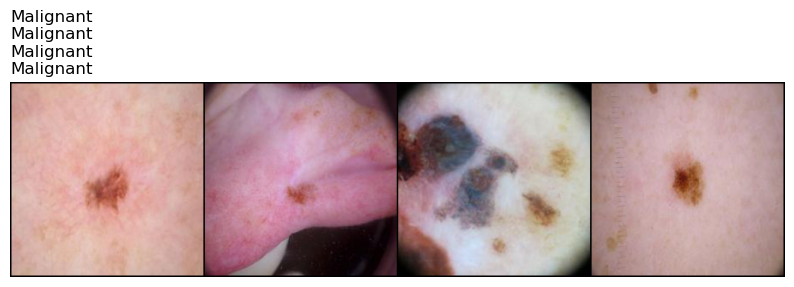

In [29]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizes all images to 256x256 pixels
    transforms.ToTensor()           # Converts the images to PyTorch tensors
])

# Define the directory paths
train_dir = 'data/train'
test_dir = 'data/test'

# Load the image data from directories
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

def imshow(img, labels, classes):
    """Function to show an image along with its labels."""
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose the dimensions to display properly
    plt.axis('off')  # Turn off axis numbers and ticks

    # Set titles for each image in the batch
    titles = [classes[label] for label in labels]
    plt.title("\n".join(titles), loc='left', fontsize=12)  # Use newline to separate titles clearly

# Get a batch of training images
images, labels = next(iter(train_loader))

# Display the images with titles
imshow(torchvision.utils.make_grid(images, nrow=4), labels, train_dataset.classes)


In [30]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = self.dropout3(self.act3(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define data augmentations and transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with applied transformations
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='data/test', transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Using test data as validation for example

# Learning rate finder function
def find_lr(model, train_loader, init_value=1e-8, final_value=10., beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    log_lr = []
    log_loss = []
    avg_loss = 0.
    best_loss = float('inf')
    best_lr = lr
    batch_idx = 0

    for data, target in train_loader:
        batch_idx += 1
        optimizer.param_groups[0]['lr'] = lr
        outputs = model(data)
        loss = criterion(outputs, target)

        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_idx)
        if smoothed_loss < best_loss:
            best_loss = smoothed_loss
            best_lr = lr

        if batch_idx > 1 and smoothed_loss > 4 * best_loss:
            break

        log_lr.append(np.log10(lr))
        log_loss.append(smoothed_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr *= mult

    plt.plot(log_lr, log_loss)
    plt.xlabel("Log Learning Rate")
    plt.ylabel("Smoothed Loss")
    plt.title("Learning Rate Finder")
    plt.show()

    return best_lr

# Initialize the model
model = SimpleCNN()

# Find optimal learning rate
optimal_lr = find_lr(model, train_loader)
print("Optimal Learning Rate:", optimal_lr)

# Setup optimizer with found learning rate
optimizer = optim.Adam(model.parameters(), lr=optimal_lr)
criterion = nn.CrossEntropyLoss()

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data, targets in val_loader:
                outputs = model(data)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Train the model with early stopping
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5)

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

# Evaluate the trained model
evaluate_model(trained_model, val_loader)


KeyboardInterrupt: 